In [3]:
!nvidia-smi

Mon Feb 21 14:34:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:08:00.0 Off |                    0 |
| N/A   24C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:0B:00.0 Off |                    0 |
| N/A   

In [10]:
data_folder = '/media/QNAP/People/BartLiefers/ROP/220118/ROP/Images/Media'
import os
import csv
import json
from collections import Counter
from itertools import combinations

from PIL import Image
import numpy as np

from keras.applications import DenseNet201
from keras.models import Model
from keras.layers import MaxPool2D, Dense, Conv2D, Flatten, Softmax
from keras.optimizers import Adam

from sklearn.metrics import roc_auc_score
import batch_preparation


from matplotlib import pylab as plt
from IPython.display import clear_output


## Config

In [11]:
input_size = 512, 512

batch_size = 6
learning_rate = 1e-5

n_iterations_per_epoch = 100
n_epochs = 100

grading_labels = {
    'normal': [1,0,0],
    'pre-plus': [0,1,0],
    'plus': [0,0,1],
}
n_classes = len(grading_labels)

model_folder = 'models_220221'
import os
os.makedirs(model_folder)

## Load data

In [12]:
with open('../src/data/new_data_split.csv', 'r') as f:
    split = list(csv.reader(f))
    header = split[0]
    data = split[1:]
    
len(data)

7414

In [13]:
header

['file', 'subset', 'CH', 'JT', 'CK', 'SB', 'GA', 'group']

In [14]:
Counter(d[-1] for d in data)

Counter({'normal': 6220, 'ungradable': 487, 'pre-plus': 362, 'plus': 345})

In [15]:
Counter(d[1] for d in data)

Counter({'fold_0': 1349,
         'excluded': 594,
         'test': 200,
         'fold_1': 1353,
         'fold_2': 1313,
         'fold_3': 1300,
         'fold_4': 1305})

In [16]:
all_files = [d[0] for d in data]

In [17]:
len(all_files)

7414

In [18]:
# load all images into memory (takes a while)
all_data = {
    path: np.array(Image.open(os.path.join(data_folder, path)))[:,:,:3]
    for path in all_files
}

## Folds

In [19]:
fold_names = 'fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4', 'test', 'excluded'

# {foldname: [(filename, grading), ...]}
# using group label (row[-1])
fold_files = {fold_name: [(row[0], row[-1]) for row in data if row[1] == fold_name]
             for fold_name in fold_names}

In [20]:
for name, files in fold_files.items():
    print(name, len(files))

fold_0 1349
fold_1 1353
fold_2 1313
fold_3 1300
fold_4 1305
test 200
excluded 594


In [21]:
def get_grading_data(folds, grading_labels):
    
    # all files and gradings in folds
    files = [(path, grading) for fold_name, fold_items in fold_files.items()
                  for path, grading in fold_items if fold_name in folds]
    
    # map grading to list of raw images (np array)
    result = {
        grading: [all_data[path] for path, g in files if grading == g]
        for grading in grading_labels
    }
    print({k:len(v) for k, v in result.items()})
    return result

def get_data(validation_fold, grading_labels):
    training_folds = {f for f in fold_names if f not in (validation_fold, 'test', 'excluded') }
    
    training_data = get_grading_data(training_folds, grading_labels)
    validation_data = get_grading_data((validation_fold, ), grading_labels)
    
    return training_data, validation_data

## Model

In [22]:
def get_model():
    
    base_model = DenseNet201(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=(*input_size, n_classes),
        pooling=None,
    )

    l = MaxPool2D()(base_model.output)
    l = Conv2D(filters=512, kernel_size=(1, 1), activation='relu')(l)
    l = Flatten()(l)
    l = Dense(units=n_classes)(l)
    l = Softmax()(l)
    model = Model(base_model.input, l)
    
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy')
    return model


## Validation

In [23]:
def avg_auc(scores, grading_labels):
    return np.mean([scores[k] for k in grading_labels])

def validate(model, grading_labels, data_set_preprocessed):
    
    n = len(data_set_preprocessed)
    yt = np.zeros((n, 3))
    yp = np.zeros((n, 3))
    
    for i, (grading, x) in enumerate(data_set_preprocessed):
        yt[i] = grading_labels[grading]
        yp[i] = model.predict_on_batch(x[np.newaxis])[0]
           
    scores = {}
    for name, labels in grading_labels.items():
        i = np.argmax(labels)
        try:
            scores[name] = roc_auc_score(yt[:,i], yp[:,i])
        except:
            scores[name] = np.nan
    
    scores['avg_auc'] = avg_auc(scores, grading_labels)
    
    correct = np.argmax(yt, axis=-1) == np.argmax(yp, axis=-1)
    scores['accuracy'] = np.count_nonzero(correct) / n

    return scores


## Training loop

In [24]:
validation_fold = 'fold_0'
training_data, validation_data = get_data(validation_fold, grading_labels)

{'normal': 4642, 'pre-plus': 194, 'plus': 100}
{'normal': 1129, 'pre-plus': 41, 'plus': 35}


In [25]:
len(training_data['normal']), len(training_data['pre-plus']), len(training_data['plus'])

(4642, 194, 100)

In [26]:
def get_batches(validation_fold, grading_labels):
    training_data, validation_data = get_data(validation_fold, grading_labels)

    training_batch_preparation = batch_preparation.BatchPreparationClassBalanced(
        grading_labels, 
        training_data, 
        n_channels = 3, 
        batch_size = batch_size, 
    )

    validation_set_preprocessed = [(grading, batch_preparation.sample_patch(image, augment=False))
                                   for grading, images in validation_data.items() 
                                   for image in images]

    return training_batch_preparation, validation_set_preprocessed

In [27]:
def training_loop(validation_fold, grading_labels):
    
    model = get_model()
    
    training_batch_preparation, validation_set_preprocessed = get_batches(validation_fold, grading_labels)
    
    losses = []
    all_scores = {k:[] for k in grading_labels}
    all_scores['accuracy'] = []
    all_scores['avg_auc'] = []

    best_normal_auc = 0
    best_avg_auc = 0
    
    for epoch in range(n_epochs):
        for i in range(n_iterations_per_epoch):
            x, y = training_batch_preparation.get_batch()
            loss = model.train_on_batch(x, y)
            losses.append(loss)
           
        scores = validate(model, grading_labels, validation_set_preprocessed)
        
        improvement = False
        if scores['normal'] > best_normal_auc:
            best_normal_auc = scores['normal']
            improvement = True
        if scores['avg_auc'] > best_avg_auc:
            best_avg_auc = scores['avg_auc']
            improvement = True
            
        if improvement and epoch > 15:
            model.save('{}/val_fold_{}_epoch_{}'.format(model_folder, validation_fold, epoch))
        
        for k, v in scores.items():
            all_scores[k].append(v)
        
        display(losses, scores, all_scores, epoch)
        
    return model, losses, all_scores
        

def display(losses, scores, all_scores, epoch):
    
    clear_output()
    print(scores)    
    print('epoch: ', epoch)

    plt.plot(losses, label='loss')    
    plt.plot(np.convolve(losses, np.ones(20))/20, label='loss')    
    plt.legend()
    plt.show()

    for k, v in scores.items():
        plt.plot(all_scores[k], label=k)
    plt.legend()
    plt.show()
        
    for k, v in scores.items():
        plt.plot(np.log(1 - np.array(all_scores[k])), label=k)
    plt.legend()
    plt.show()        

{'normal': 0.7453388762912573, 'pre-plus': 0.6728241125581108, 'plus': 0.7465903143376127, 'avg_auc': 0.7215844343956602, 'accuracy': 0.683739837398374}
epoch:  2


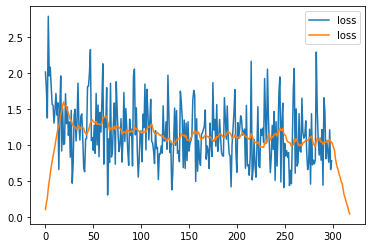

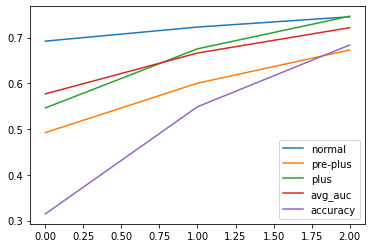

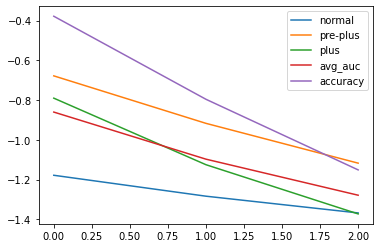

In [ ]:
for f in range(5):
    validation_fold = 'fold_{}'.format(f)
    export_file = 'scores220221_{}.json'.format(validation_fold)
    
    if os.path.exists(export_file):
        continue
        
    print('starting training loop', validation_fold)
    model, losses, all_scores = training_loop(validation_fold, grading_labels)
    with open(export_file, 'w') as f:
        json.dump({
            'losses': [float(l) for l in losses],
            'all_scores': all_scores
        }, f)

        
    